This originally was the MMAction2 Tutorial. I gutted it for our purposes

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# Load python modules needed

Similar to how you do pip install a dependency when using your computer, you must install the python packages in colab. We will need to add the install of our fork to this as well.

In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full==latest+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html

# Install mmaction2
!rm -rf mmaction2
!git clone https://github.com/open-mmlab/mmaction2.git
%cd mmaction2

!pip install -e .

# Install some optional requirements
!pip install -r requirements/optional.txt
!ls

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.7MB 44.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.1+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
Looking in links: https://download.openmmlab.com/mmcv/dist/index.html
     |████████████████████████████████| 24.4MB 121kB/s 
     |████████████████████████████████| 194kB 7.9MB/s 
Cloning into 'mmaction2'...
remote: Enumerating objects: 10253, done.
remote: Total 10253 (delta 0), reused 0 (delta 0), pack-reused 10253
Receiving objects: 100% (10253/10253), 35.95 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (7298/7298

configs  docs	     mmaction		 README_zh-CN.md   setup.cfg  tools
demo	 docs_zh_CN  mmaction2.egg-info  requirements	   setup.py
docker	 LICENSE     README.md		 requirements.txt  tests


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
0.13.0
10.1
GCC 7.3


# Loading The Model From the Checkpoint
 

In [4]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_1x1x3_100e_kinetics400_rgb/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth \
      -O checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth

--2021-04-09 21:50:47--  https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_1x1x3_100e_kinetics400_rgb/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97579339 (93M) [application/octet-stream]
Saving to: ‘checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth’

checkpoints/tsn_r50 100%[===================>]  93.06M  10.4MB/s    in 9.5s    

2021-04-09 21:50:58 (9.76 MB/s) - ‘checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth’ saved [97579339/97579339]



In [5]:
from mmaction.apis import inference_recognizer, init_recognizer

# Choose to use a config and initialize the recognizer
config = 'configs/recognition/tsn/tsn_r50_video_inference_1x1x3_100e_kinetics400_rgb.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'
# Initialize the recognizer
model = init_recognizer(config, checkpoint, device='cuda:0')

Use load_from_local loader


In [6]:
# Use the recognizer to do inference
video = 'demo/demo.mp4'
label = 'demo/label_map_k400.txt'
results = inference_recognizer(model, video, label)

In [7]:
# Let's show the results
for result in results:
    print(f'{result[0]}: ', result[1])

arm wrestling:  29.616438
rock scissors paper:  10.754841
shaking hands:  9.908401
clapping:  9.189913
massaging feet:  8.305306


# Loading the Data

This is where the data is loaded, we will need to overwrite this part and add in our data. This can either be the functions to sample and download the files OR it can be a link to a dropbox, Google drive, or other type of file hosting thing.

We will also need to make sure our code outputs the same file structure that they do in the subsection "Their Labels Format"

In [8]:
# download, decompress the data
!rm kinetics400_tiny.zip*
!rm -rf kinetics400_tiny
!wget https://download.openmmlab.com/mmaction/kinetics400_tiny.zip
!unzip kinetics400_tiny.zip > /dev/null

rm: cannot remove 'kinetics400_tiny.zip*': No such file or directory
--2021-04-09 21:51:04--  https://download.openmmlab.com/mmaction/kinetics400_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18308682 (17M) [application/zip]
Saving to: ‘kinetics400_tiny.zip’

kinetics400_tiny.zi 100%[===================>]  17.46M  13.4MB/s    in 1.3s    

2021-04-09 21:51:06 (13.4 MB/s) - ‘kinetics400_tiny.zip’ saved [18308682/18308682]



In [9]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kinetics400_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (86.2 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kinetics400_tiny
├── kinetics_tiny_train_video.txt
├── kinetics_tiny_val_video.txt
├── train
│   ├── 27_CSXByd3s.mp4
│   ├── 34XczvTaRiI.mp4
│   ├── A-wiliK50Zw.mp4
│   ├── D32_1gwq35E.mp4
│   ├── D92m0HsHjcQ.mp4
│   ├── DbX8mPslRXg.mp4
│   ├── FMlSTTpN3VY.mp4
│   ├── h10B9SVE-nk.mp4
│   ├── 

## Their Labels Format

We can either format our data like this, OR we can adjust the config to handle whatever format we want.

In [10]:
# After downloading the data, we need to check the annotation format
!cat kinetics400_tiny/kinetics_tiny_train_video.txt

D32_1gwq35E.mp4 0
iRuyZSKhHRg.mp4 1
oXy-e_P_cAI.mp4 0
34XczvTaRiI.mp4 1
h2YqqUhnR34.mp4 0
O46YA8tI530.mp4 0
kFC3KY2bOP8.mp4 1
WWP5HZJsg-o.mp4 1
phDqGd0NKoo.mp4 1
yLC9CtWU5ws.mp4 0
27_CSXByd3s.mp4 1
IyfILH9lBRo.mp4 1
T_TMNGzVrDk.mp4 1
TkkZPZHbAKA.mp4 0
PnOe3GZRVX8.mp4 1
soEcZZsBmDs.mp4 1
FMlSTTpN3VY.mp4 1
WaS0qwP46Us.mp4 0
A-wiliK50Zw.mp4 1
oMrZaozOvdQ.mp4 1
ZQV4U2KQ370.mp4 0
DbX8mPslRXg.mp4 1
h10B9SVE-nk.mp4 1
P5M-hAts7MQ.mp4 0
R8HXQkdgKWA.mp4 0
D92m0HsHjcQ.mp4 0
RqnKtCEoEcA.mp4 0
LvcFDgCAXQs.mp4 0
xGY2dP0YUjA.mp4 0
Wh_YPQdH1Zg.mp4 0


According to the format defined in [`VideoDataset`](./datasets/video_dataset.py), each line indicates a sample video with the filepath and label, which are split with a whitespace.

# Load/Modify the config of the model

In [11]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

Modify the config loaded in previous cell for the task. The only things we need to change are the paths to the data.


In [12]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'kinetics400_tiny/train/'
cfg.data_root_val = 'kinetics400_tiny/val/'
cfg.ann_file_train = 'kinetics400_tiny/kinetics_tiny_train_video.txt'
cfg.ann_file_val = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
cfg.ann_file_test = 'kinetics400_tiny/kinetics_tiny_val_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
cfg.data.test.data_prefix = 'kinetics400_tiny/val/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'kinetics400_tiny/kinetics_tiny_train_video.txt'
cfg.data.train.data_prefix = 'kinetics400_tiny/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'kinetics400_tiny/kinetics_tiny_val_video.txt'
cfg.data.val.data_prefix = 'kinetics400_tiny/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 2
# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = cfg.data.videos_per_gpu // 16
cfg.optimizer.lr = cfg.optimizer.lr / 8 / 16
cfg.total_epochs = 30

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 10
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNet',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False),
    cls_head=dict(
        type='TSNHead',
        num_classes=2,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.4,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(type='SGD', lr=7.8125e-05, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dict(policy='step', step=[40, 80])
total_epochs = 30
checkpoint_config = dict(interval=10)
log_config = dict(interval=5, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'VideoDataset'
data_root =

# Training

Training loop of the model

In [13]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

Use load_from_torchvision loader


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


2021-04-09 21:51:14,761 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2021-04-09 21:51:14,814 - mmaction - INFO - load checkpoint from ./checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth
2021-04-09 21:51:14,816 - mmaction - INFO - Use load_from_local loader
2021-04-09 21:51:14,906 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([2]).
2021-04-09 21:51:14,910 - mmaction - INFO - Start running, host: root@1a8a749a3b71, work_dir: /content/mmaction2/tutorial_exps
2021-04-09 21:51:14,915 - mmaction - INFO - workflow: [('train', 1)], max: 30 epochs
/content/mmaction2/mmaction/core/evaluati

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.8 task/s, elapsed: 2s, ETA:     0s

2021-04-09 21:51:48,538 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-09 21:51:48,539 - mmaction - INFO - 
top1_acc	0.7000
top5_acc	1.0000
2021-04-09 21:51:48,544 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-09 21:51:48,549 - mmaction - INFO - 
mean_acc	0.7000
2021-04-09 21:51:48,881 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-04-09 21:51:48,882 - mmaction - INFO - Best top1_acc is 0.7000 at 5 epoch.
2021-04-09 21:51:48,885 - mmaction - INFO - Epoch(val) [5][15]	top1_acc: 0.7000, top5_acc: 1.0000, mean_class_accuracy: 0.7000
2021-04-09 21:51:53,630 - mmaction - INFO - Epoch [6][5/15]	lr: 7.813e-05, eta: 0:02:47, time: 0.947, data_time: 0.740, memory: 2918, top1_acc: 0.5000, top5_acc: 1.0000, loss_cls: 0.6695, loss: 0.6695, grad_norm: 11.0231
2021-04-09 21:51:54,525 - mmaction - INFO - Epoch [6][10/15]	lr: 7.813e-05, eta: 0:02:38, time: 0.179, data_time: 0.001, memory: 2918, top1_acc: 0.6000, top5_acc: 1.0000, loss_cl

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.7 task/s, elapsed: 2s, ETA:     0s

2021-04-09 21:52:23,294 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-09 21:52:23,295 - mmaction - INFO - 
top1_acc	0.9000
top5_acc	1.0000
2021-04-09 21:52:23,302 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-09 21:52:23,304 - mmaction - INFO - 
mean_acc	0.9000
2021-04-09 21:52:23,686 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-04-09 21:52:23,689 - mmaction - INFO - Best top1_acc is 0.9000 at 10 epoch.
2021-04-09 21:52:23,693 - mmaction - INFO - Epoch(val) [10][15]	top1_acc: 0.9000, top5_acc: 1.0000, mean_class_accuracy: 0.9000
2021-04-09 21:52:27,947 - mmaction - INFO - Epoch [11][5/15]	lr: 7.813e-05, eta: 0:02:08, time: 0.849, data_time: 0.639, memory: 2918, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5358, loss: 0.5358, grad_norm: 8.8140
2021-04-09 21:52:28,961 - mmaction - INFO - Epoch [11][10/15]	lr: 7.813e-05, eta: 0:02:04, time: 0.202, data_time: 0.008, memory: 2918, top1_acc: 0.8000, top5_acc: 1.0000, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.8 task/s, elapsed: 2s, ETA:     0s

2021-04-09 21:52:57,425 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-09 21:52:57,427 - mmaction - INFO - 
top1_acc	0.8000
top5_acc	1.0000
2021-04-09 21:52:57,429 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-09 21:52:57,434 - mmaction - INFO - 
mean_acc	0.8000
2021-04-09 21:52:57,435 - mmaction - INFO - Epoch(val) [15][15]	top1_acc: 0.8000, top5_acc: 1.0000, mean_class_accuracy: 0.8000
2021-04-09 21:53:01,546 - mmaction - INFO - Epoch [16][5/15]	lr: 7.813e-05, eta: 0:01:34, time: 0.821, data_time: 0.602, memory: 2918, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5428, loss: 0.5428, grad_norm: 10.0107
2021-04-09 21:53:02,913 - mmaction - INFO - Epoch [16][10/15]	lr: 7.813e-05, eta: 0:01:31, time: 0.273, data_time: 0.088, memory: 2918, top1_acc: 0.7000, top5_acc: 1.0000, loss_cls: 0.6096, loss: 0.6096, grad_norm: 11.1674
2021-04-09 21:53:03,783 - mmaction - INFO - Epoch [16][15/15]	lr: 7.813e-05, eta: 0:01:28, time: 0.174, data_time: 0.001, memory: 2918, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.6 task/s, elapsed: 2s, ETA:     0s

2021-04-09 21:53:32,150 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-09 21:53:32,152 - mmaction - INFO - 
top1_acc	0.9000
top5_acc	1.0000
2021-04-09 21:53:32,153 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-09 21:53:32,157 - mmaction - INFO - 
mean_acc	0.9000
2021-04-09 21:53:32,159 - mmaction - INFO - Epoch(val) [20][15]	top1_acc: 0.9000, top5_acc: 1.0000, mean_class_accuracy: 0.9000
2021-04-09 21:53:36,332 - mmaction - INFO - Epoch [21][5/15]	lr: 7.813e-05, eta: 0:01:02, time: 0.832, data_time: 0.607, memory: 2918, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.4516, loss: 0.4516, grad_norm: 8.3884
2021-04-09 21:53:37,601 - mmaction - INFO - Epoch [21][10/15]	lr: 7.813e-05, eta: 0:00:59, time: 0.255, data_time: 0.042, memory: 2918, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.4540, loss: 0.4540, grad_norm: 9.0834
2021-04-09 21:53:38,498 - mmaction - INFO - Epoch [21][15/15]	lr: 7.813e-05, eta: 0:00:57, time: 0.179, data_time: 0.002, memory: 2918, to

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.7 task/s, elapsed: 2s, ETA:     0s

2021-04-09 21:54:06,106 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-09 21:54:06,108 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-04-09 21:54:06,112 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-09 21:54:06,117 - mmaction - INFO - 
mean_acc	1.0000
2021-04-09 21:54:06,441 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2021-04-09 21:54:06,442 - mmaction - INFO - Best top1_acc is 1.0000 at 25 epoch.
2021-04-09 21:54:06,443 - mmaction - INFO - Epoch(val) [25][15]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000
2021-04-09 21:54:10,789 - mmaction - INFO - Epoch [26][5/15]	lr: 7.813e-05, eta: 0:00:30, time: 0.867, data_time: 0.631, memory: 2918, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.3757, loss: 0.3757, grad_norm: 7.9593
2021-04-09 21:54:12,079 - mmaction - INFO - Epoch [26][10/15]	lr: 7.813e-05, eta: 0:00:27, time: 0.258, data_time: 0.057, memory: 2918, top1_acc: 0.5000, top5_acc: 1.0000, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 5.5 task/s, elapsed: 2s, ETA:     0s

2021-04-09 21:54:40,757 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-09 21:54:40,758 - mmaction - INFO - 
top1_acc	1.0000
top5_acc	1.0000
2021-04-09 21:54:40,763 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-09 21:54:40,766 - mmaction - INFO - 
mean_acc	1.0000
2021-04-09 21:54:40,769 - mmaction - INFO - Epoch(val) [30][15]	top1_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 1.0000


# Evaluation


In [14]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)



In [15]:
md_model = MMDataParallel(model, device_ids=[0])

outputs = single_gpu_test(md_model, data_loader)
eval_config = cfg.evaluation
eval_config.pop('interval',None)
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 2.1 task/s, elapsed: 5s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	1.0000
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	1.0000
top1_acc: 1.0000
top5_acc: 1.0000
mean_class_accuracy: 1.0000


In [16]:
data_loader

In [17]:
imgs =[]
labels = []
for d in data_loader:
    imgs.append(d['imgs'].to(torch.device('cuda')))
    labels.append(d['label'].to(torch.device('cuda')))
labels = torch.stack(labels)
# imgs = imgs.view(imgs.size(0),imgs.size(1),imgs.size(-2),imgs.size(-1),imgs.size(2))

In [18]:
!pwd

/content/mmaction2


In [19]:

!rm -rf adversarial-robustness-toolbox
!rm -rf adversarial_robustness_toolbox
!git clone https://github.com/gabeorlanski/adversarial-robustness-toolbox.git

%cd adversarial-robustness-toolbox/
!git fetch
!git checkout current_over_the_air
%cd ..
!mv adversarial-robustness-toolbox adversarial_robustness_toolbox 

Cloning into 'adversarial-robustness-toolbox'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 54082 (delta 2), reused 0 (delta 0), pack-reused 54074
Receiving objects: 100% (54082/54082), 185.42 MiB | 31.28 MiB/s, done.
Resolving deltas: 100% (42736/42736), done.
/content/mmaction2/adversarial-robustness-toolbox
Branch 'current_over_the_air' set up to track remote branch 'current_over_the_air' from 'origin'.
Switched to a new branch 'current_over_the_air'
/content/mmaction2


In [20]:
from scipy.special import expit
from adversarial_robustness_toolbox.over_the_air import paper_equations
from importlib import reload
from tqdm.notebook import tqdm
torch.manual_seed(2020)
reload(paper_equations)
import numpy as np
from torch import nn
delta = nn.parameter.Parameter(torch.zeros(imgs[0].shape[1],3,1,1).normal_(mean=0.,std=.2).to(torch.device('cuda')),requires_grad=True)
optimizer = torch.optim.AdamW([delta],lr=1.)
schedueler = torch.optim.lr_scheduler.StepLR(optimizer, 10)
for i in tqdm(range(200)):
    optimizer.zero_grad()
    preds = []
    with torch.no_grad():
        for vid in imgs:
            preds.append(expit(model(vid+delta,return_loss=False)))
    preds = torch.tensor(preds).to(torch.device('cuda')).squeeze(1)
    loss = paper_equations.objectiveFunc(
        preds,
        labels.squeeze(1),
        delta,
        .6,
        1,
        1,
        .25
    )
    if (i+1) % 5 == 0:
        tqdm.write(f"Epoch {i+1:>4}: Loss {loss:.7f}")
    loss.backward()
    optimizer.step()
    schedueler.step()
    

Epoch    5: Loss 2.8424504
Epoch   10: Loss 1.6641793
Epoch   15: Loss 0.8904816
Epoch   20: Loss 0.5817369
Epoch   25: Loss 0.5749563
Epoch   30: Loss 0.5745706
Epoch   35: Loss 0.5741845
Epoch   40: Loss 0.5738750
Epoch   45: Loss 0.5737693
Epoch   50: Loss 0.5737231
Epoch   55: Loss 0.5737091
Epoch   60: Loss 0.5737035
Epoch   65: Loss 0.5737020
Epoch   70: Loss 0.5737014
Epoch   75: Loss 0.5737012
Epoch   80: Loss 0.5737012
Epoch   85: Loss 0.5737011
Epoch   90: Loss 0.5737011
Epoch   95: Loss 0.5737011
Epoch  100: Loss 0.5737011
Epoch  105: Loss 0.5737011
Epoch  110: Loss 0.5737011
Epoch  115: Loss 0.5737011
Epoch  120: Loss 0.5737011
Epoch  125: Loss 0.5737011
Epoch  130: Loss 0.5737011
Epoch  135: Loss 0.5737011
Epoch  140: Loss 0.5737011
Epoch  145: Loss 0.5737011
Epoch  150: Loss 0.5737011
Epoch  155: Loss 0.5737011
Epoch  160: Loss 0.5737011
Epoch  165: Loss 0.5737011
Epoch  170: Loss 0.5737011
Epoch  175: Loss 0.5737011
Epoch  180: Loss 0.5737011
Epoch  185: Loss 0.5737011
E

In [21]:
preds = []
with torch.no_grad():
    for vid in imgs:
        preds.append(np.argmax(expit(model(vid+delta,return_loss=False)),axis=1))
print(f"Original:")
eval_config = cfg.evaluation
eval_config.pop('interval',None)
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
print(f"\n\n\nAttack:")
eval_res = dataset.evaluate(preds, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

Original:

Evaluating top_k_accuracy ...

top1_acc	1.0000
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	1.0000
top1_acc: 1.0000
top5_acc: 1.0000
mean_class_accuracy: 1.0000



Attack:

Evaluating top_k_accuracy ...

top1_acc	0.5000
top5_acc	0.5000

Evaluating mean_class_accuracy ...

mean_acc	0.5000
top1_acc: 0.5000
top5_acc: 0.5000
mean_class_accuracy: 0.5000


In [22]:
torch.norm(delta)

tensor(0.7349, device='cuda:0', grad_fn=<NormBackward0>)

In [23]:
data_loader

In [24]:
imgs =[]
labels = []
for d in data_loader:
    imgs.append(d['imgs'].to(torch.device('cuda')))
    labels.append(d['label'].to(torch.device('cuda')))
labels = torch.stack(labels)
# imgs = imgs.view(imgs.size(0),imgs.size(1),imgs.size(-2),imgs.size(-1),imgs.size(2))

In [25]:
!pwd

/content/mmaction2


In [26]:

!rm -rf adversarial-robustness-toolbox
!rm -rf adversarial_robustness_toolbox
!git clone https://github.com/gabeorlanski/adversarial-robustness-toolbox.git

%cd adversarial-robustness-toolbox/
!git fetch
!git checkout current_over_the_air
%cd ..
!mv adversarial-robustness-toolbox adversarial_robustness_toolbox 

Cloning into 'adversarial-robustness-toolbox'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 54082 (delta 2), reused 0 (delta 0), pack-reused 54074
Receiving objects: 100% (54082/54082), 185.40 MiB | 34.96 MiB/s, done.
Resolving deltas: 100% (42735/42735), done.
/content/mmaction2/adversarial-robustness-toolbox
Branch 'current_over_the_air' set up to track remote branch 'current_over_the_air' from 'origin'.
Switched to a new branch 'current_over_the_air'
/content/mmaction2


In [27]:
from scipy.special import expit
from adversarial_robustness_toolbox.over_the_air import paper_equations
from importlib import reload
from tqdm.notebook import tqdm
torch.manual_seed(2020)
reload(paper_equations)
import numpy as np
from torch import nn
delta = nn.parameter.Parameter(torch.zeros(imgs[0].shape[1],3,1,1).normal_(mean=0.,std=.2).to(torch.device('cuda')),requires_grad=True)
optimizer = torch.optim.AdamW([delta],lr=1.)
schedueler = torch.optim.lr_scheduler.StepLR(optimizer, 10)
for i in tqdm(range(200)):
    optimizer.zero_grad()
    preds = []
    with torch.no_grad():
        for vid in imgs:
            preds.append(expit(model(vid+delta,return_loss=False)))
    preds = torch.tensor(preds).to(torch.device('cuda')).squeeze(1)
    loss = paper_equations.objectiveFunc(
        preds,
        labels.squeeze(1),
        delta,
        .6,
        1,
        1,
        .25
    )
    if (i+1) % 5 == 0:
        tqdm.write(f"Epoch {i+1:>4}: Loss {loss:.7f}")
    loss.backward()
    optimizer.step()
    schedueler.step()
    

Epoch    5: Loss 2.8424504
Epoch   10: Loss 1.6641793
Epoch   15: Loss 0.8904816
Epoch   20: Loss 0.5817369
Epoch   25: Loss 0.5749563
Epoch   30: Loss 0.5745706
Epoch   35: Loss 0.5741845
Epoch   40: Loss 0.5738750
Epoch   45: Loss 0.5737693
Epoch   50: Loss 0.5737231
Epoch   55: Loss 0.5737091
Epoch   60: Loss 0.5737035
Epoch   65: Loss 0.5737020
Epoch   70: Loss 0.5737014
Epoch   75: Loss 0.5737012
Epoch   80: Loss 0.5737012
Epoch   85: Loss 0.5737011
Epoch   90: Loss 0.5737011
Epoch   95: Loss 0.5737011
Epoch  100: Loss 0.5737011
Epoch  105: Loss 0.5737011
Epoch  110: Loss 0.5737011
Epoch  115: Loss 0.5737011
Epoch  120: Loss 0.5737011
Epoch  125: Loss 0.5737011
Epoch  130: Loss 0.5737011
Epoch  135: Loss 0.5737011
Epoch  140: Loss 0.5737011
Epoch  145: Loss 0.5737011
Epoch  150: Loss 0.5737011
Epoch  155: Loss 0.5737011
Epoch  160: Loss 0.5737011
Epoch  165: Loss 0.5737011
Epoch  170: Loss 0.5737011
Epoch  175: Loss 0.5737011
Epoch  180: Loss 0.5737011
Epoch  185: Loss 0.5737011
E

In [28]:
preds = []
with torch.no_grad():
    for vid in imgs:
        preds.append(np.argmax(expit(model(vid+delta,return_loss=False)),axis=1))
print(f"Original:")
eval_config = cfg.evaluation
eval_config.pop('interval',None)
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
print(f"\n\n\nAttack:")
eval_res = dataset.evaluate(preds, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

Original:

Evaluating top_k_accuracy ...

top1_acc	1.0000
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	1.0000
top1_acc: 1.0000
top5_acc: 1.0000
mean_class_accuracy: 1.0000



Attack:

Evaluating top_k_accuracy ...

top1_acc	0.5000
top5_acc	0.5000

Evaluating mean_class_accuracy ...

mean_acc	0.5000
top1_acc: 0.5000
top5_acc: 0.5000
mean_class_accuracy: 0.5000


In [29]:
torch.norm(delta)

tensor(0.7349, device='cuda:0', grad_fn=<NormBackward0>)

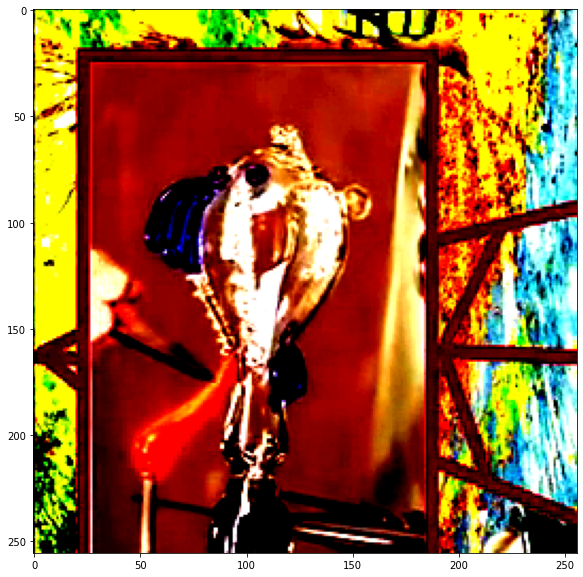

In [32]:
import matplotlib.pyplot as plt
flg, ax = plt.subplots(figsize=(10,10))
ax.imshow(torch.clamp(imgs[0].squeeze(0)[15],0,1).cpu().numpy().T)